### Library Import

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../..")

from src.sanity import *

In [3]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

### Load dataset 

In [4]:
from src.load_datasets import load_climate_change_data


dataframe = (
    load_climate_change_data()
    .pipe(format_datetime, col="Date Time", format='mixed')
    .pipe(set_index, col="Date Time")
    .pipe(resample_data, freq="H")
    .pipe(interpolate_column)
)

print(f"dataframe shape {dataframe.shape}")

dataframe = dataframe[
    ["p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)"]
].copy(deep=True)

dataframe.head()

format_datetime: DF Shape (420551, 15)
set_index: DF Shape (420551, 14)
resample_Data: DF Shape (70129, 14)
interpolate_columns: DF Shape (70129, 14)
dataframe shape (70129, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%)
Date Time,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000
2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333
2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333
2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000
2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333


In [5]:
dataframe.isna().sum()

p (mbar)       0
T (degC)       0
Tpot (K)       0
Tdew (degC)    0
rh (%)         0
dtype: int64

In [6]:
# dataframe.info()
# dataframe.isna().sum()
corr = dataframe.corr()
corr.style.background_gradient(cmap="coolwarm")

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%)
p (mbar),1.000000,-0.044493,-0.124053,-0.065985,-0.019277
T (degC),-0.044493,1.000000,0.996810,0.896871,-0.572036
Tpot (K),-0.124053,0.996810,1.000000,0.896059,-0.566696
Tdew (degC),-0.065985,0.896871,0.896059,1.000000,-0.158644
rh (%),-0.019277,-0.572036,-0.566696,-0.158644,1.000000


### Test Train split

train_xy and test_xy size: (70099, 5), (30, 5)

y_train and x_train size (70099,), (70099, 4)
y_test  and x_test  size (30,),  (30, 4)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Tdew (degC)'>)

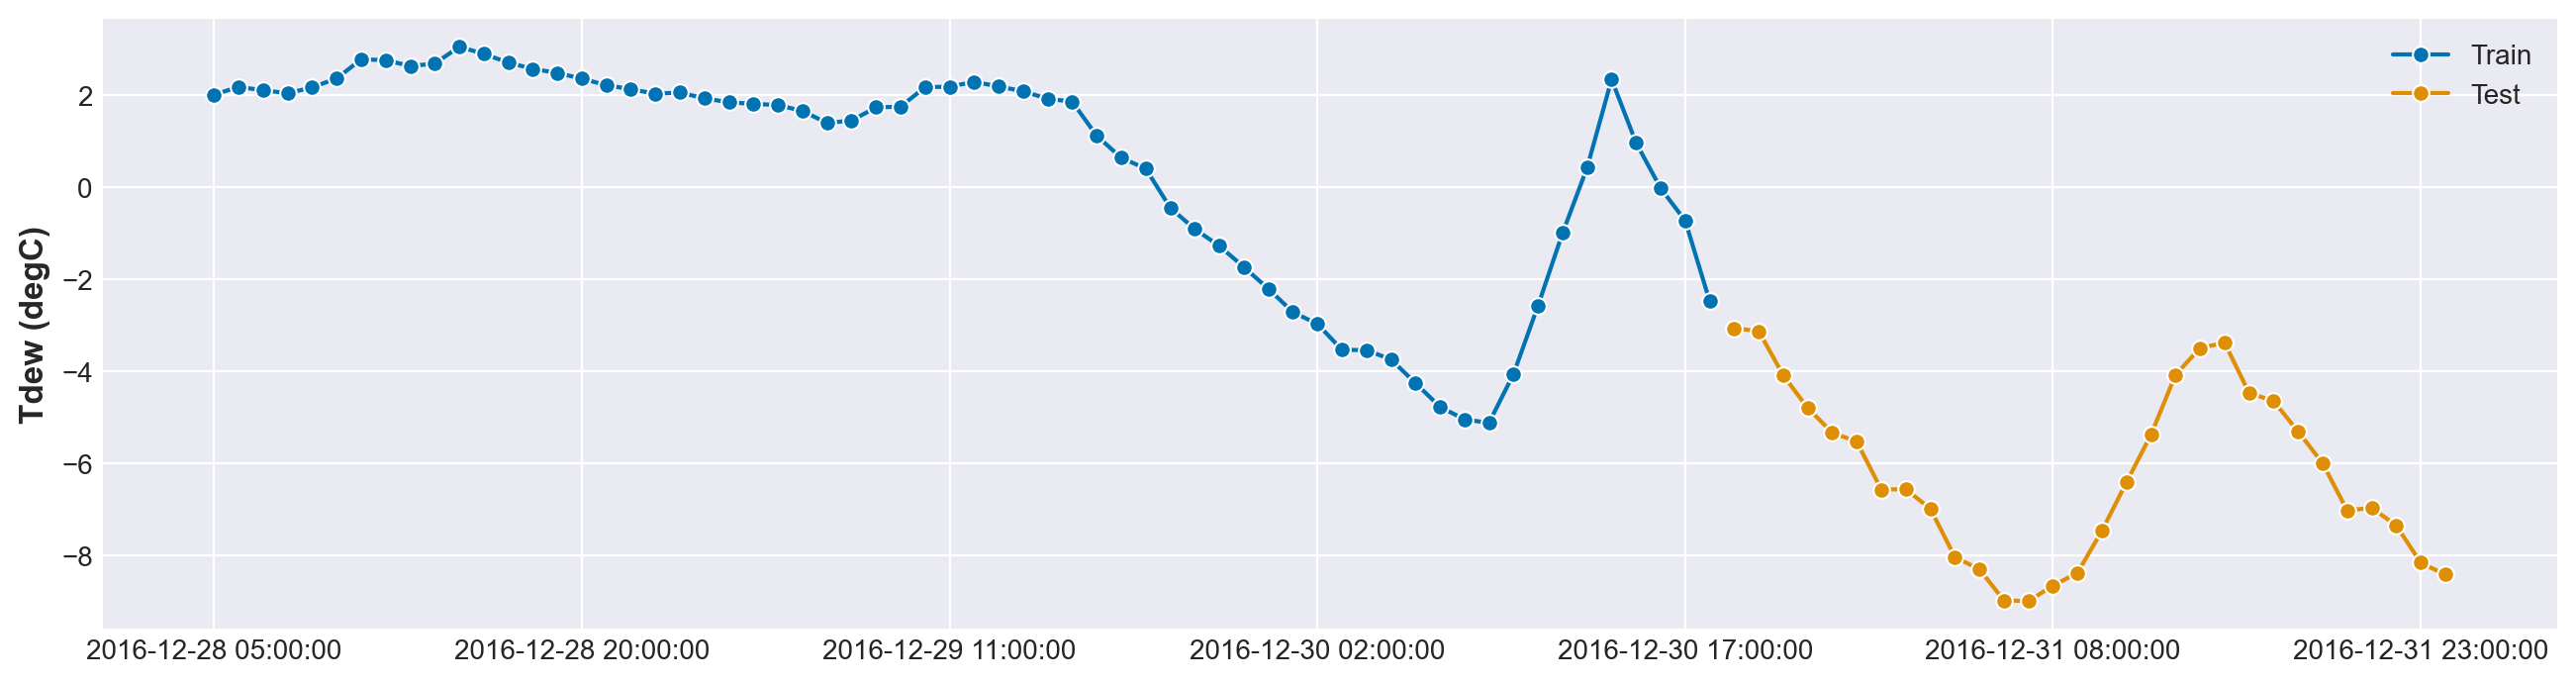

In [7]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "Tdew (degC)"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=30)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(62), y_test, labels=["Train", "Test"])

#### Huyper Parameter Selection 

intital_window_size 70024 , step_length 15 for fold 5


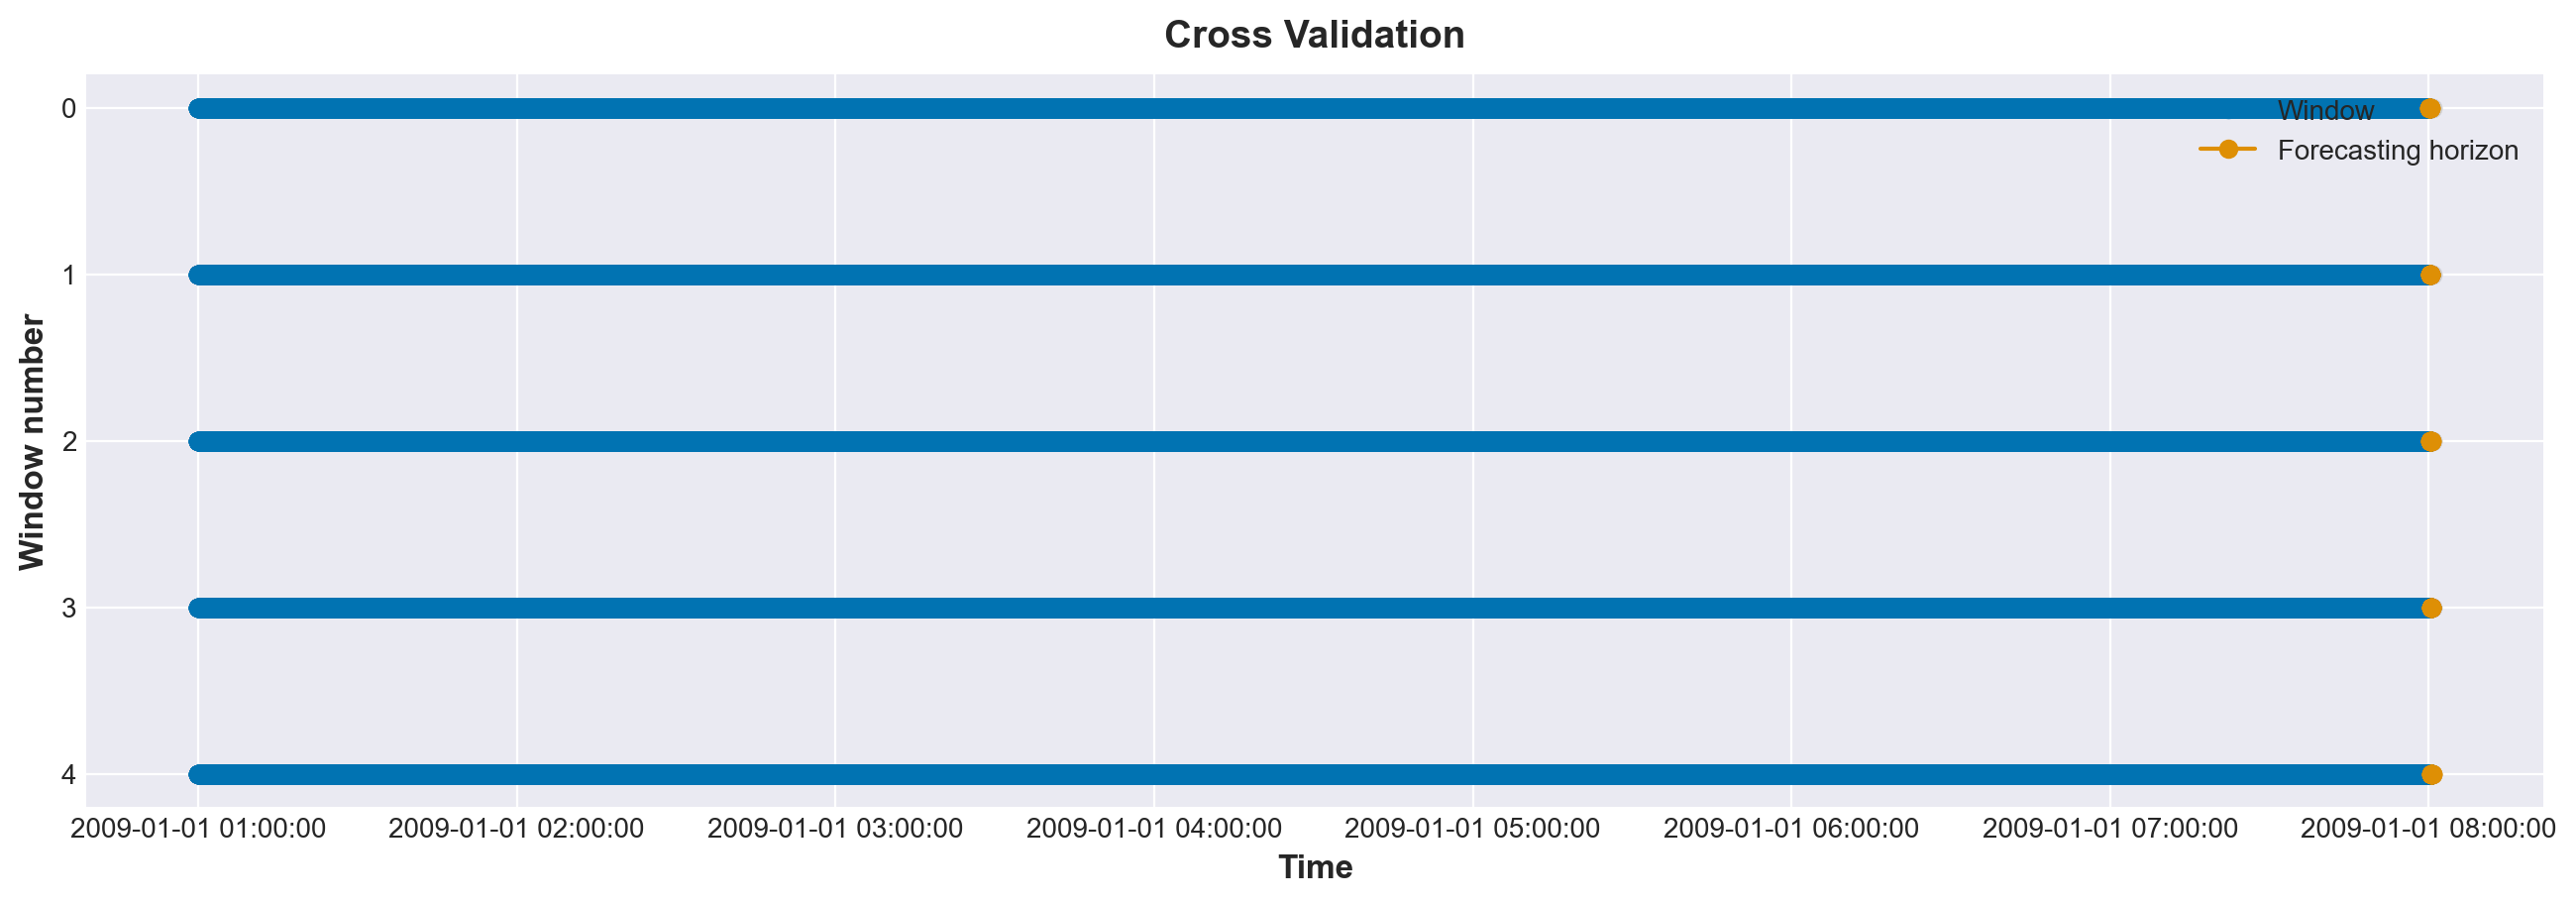

In [8]:
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = np.arange(1, TEST_SIZE + 1)

y_size = len(y_train)

fold = 5

step_length = len(fh)

fh_max_length = max(fh)

intital_window_size = y_size - ((fold - 1) * step_length + 1 * fh_max_length)

# intital_window_size = int(y_train.shape[0] * 0.80)

print(
    f"intital_window_size {intital_window_size} , step_length {step_length} for fold {fold}"
)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

plot_windows(cv, y_train, title="Cross Validation")

In [9]:
%%time

from sklearn.preprocessing import MinMaxScaler

try:
    from sklearnex.linear_model import BayesianRidge

    print("Importing sklearnex Ridge")
except ImportError:
    from sklearn.linear_model import BayesianRidge

from sktime.forecasting.compose import (
    ForecastingPipeline,
    make_reduction,
    TransformedTargetForecaster,
)
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.detrend import (
    Detrender,
    Deseasonalizer,
    ConditionalDeseasonalizer,
)
from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.forecasting.model_selection import ForecastingGridSearchCV, ForecastingRandomizedSearchCV
from sktime.performance_metrics.forecasting import MeanAbsoluteError

param_grid = {
    # "forecaster__deseasonalizer__model": ["additive", "multiplicative"],
    "scaler_x__passthrough": [True, False],
    "forecaster__deseasonalizer__model": ["additive"],
    "forecaster__deseasonalizer__sp": [24],
    "forecaster__detrender__forecaster__degree": [1, 2],
    "forecaster__reducer__window_length": [24],
    "forecaster__reducer__estimator__alpha_1": [0.01, 0.1],
    "forecaster__reducer__estimator__alpha_2": [0.01, 0.1],
    "forecaster__reducer__estimator__lambda_1": [0.01, 0.1],
    "forecaster__reducer__estimator__lambda_2": [0.01, 0.1],
    "forecaster__reducer__estimator__compute_score": [True, False],
    "forecaster__reducer__estimator__fit_intercept": [True, False],
}


forecaster_pipe = ForecastingPipeline(
    steps=[
        (
            "x_transforner",
            TransformerPipeline(
                steps=[("imputer_x", Imputer(method="ffill", random_state=80))]
            ),
        ),
        (
            "scaler_x",
            OptionalPassthrough(
                TabularToSeriesAdaptor(MinMaxScaler()), passthrough=False
            ),
        ),
        (
            "forecaster",
            TransformedTargetForecaster(
                steps=[
                    ("imputer_y", Imputer(method="ffill", random_state=80)),
                    (
                        "deseasonalizer",
                        ConditionalDeseasonalizer(model="additive", sp=24),
                    ),
                    (
                        "detrender",
                        Detrender(forecaster=PolynomialTrendForecaster(degree=1)),
                    ),
                    (
                        "reducer",
                        make_reduction(
                            estimator=BayesianRidge(),
                            scitype="tabular-regressor",
                            window_length=10,
                            strategy="recursive",
                            pooling="global",
                        ),
                    ),
                ]
            ),
        ),
    ]
)

fh = np.arange(1, TEST_SIZE + 1)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

print(f"Number of CPU Count:   {os.cpu_count()}")

n_cpu = os.cpu_count() - 1 if os.cpu_count() > 2 else 1


# gscv = ForecastingGridSearchCV(
#    forecaster_pipe,
#    strategy="refit",
#    scoring=MeanAbsoluteError(),
#    cv=cv,
#    param_grid=param_grid,
#    verbose=10,
#    n_jobs=-1,
#    refit=True,
#    error_score="raise",
#    backend='loky',
#    #n_iter=12
# )

# gscv.fit(y_train, X=x_train, fh=fh)

# print("Best Params", gscv.best_params_)
# print("Best scores", gscv.best_score_)
# print('Best Params', gscv.best_forecaster_)


Number of CPU Count:   12
CPU times: total: 31.2 ms
Wall time: 49.6 ms


In [21]:
forecaster = forecaster_pipe.clone()

from sklearn.linear_model import LinearRegression

forecaster_updated = forecaster.set_params(forecaster__reducer__estimator=LinearRegression())

forecaster_updated.get_params()

{'steps': [('x_transforner',
   TransformerPipeline(steps=[('imputer_x',
                               Imputer(method='ffill', random_state=80))])),
  ('scaler_x',
   OptionalPassthrough(transformer=TabularToSeriesAdaptor(transformer=MinMaxScaler()))),
  ('forecaster',
   TransformedTargetForecaster(steps=[('imputer_y',
                                       Imputer(method='ffill', random_state=80)),
                                      ('deseasonalizer',
                                       ConditionalDeseasonalizer(sp=24)),
                                      ('detrender',
                                       Detrender(forecaster=PolynomialTrendForecaster())),
                                      ('reducer',
                                       RecursiveTabularRegressionForecaster(estimator=LinearRegression(),
                                                                            pooling='global'))]))],
 'x_transforner': TransformerPipeline(steps=[('imputer_x',
      

In [17]:
import ray
from ray import tune

from ray.tune.experiment.trial import Trial
from ray.tune import Trainable

from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
)

class TTrainable(Trainable):
    
    def setup(self, config, estimator=None, cv=None, X=None, y=None, fh=None):
        self.h_params={k: list([v]) for k,v in config.items()}
        #self.estimator = estimator
        #self.estimator.set_params(**self.h_params)
        self.X = X
        self.y = y
        self.fh = fh
        self.estimator = ForecastingGridSearchCV(
            estimator,
            strategy="refit",
            scoring=MeanAbsoluteError(),
            cv=cv,
            param_grid=self.h_params,
            n_jobs=1,
            refit=True,
            error_score="raise",
            backend='loky',
        )

    def step(self):  # This is called iteratively.
        self.estimator.fit(self.y, X=self.X, fh=self.fh)
        return {"score": self.estimator.best_score_}
        
fh = np.arange(1, TEST_SIZE + 1)

tuner_partial = tune.with_parameters(
    TTrainable,
    estimator = forecaster_pipe,
    cv=cv,
    X=x_train,
    y=y_train,
    fh=fh
)

#tuner = tune.Tuner(
#    tuner_partial,
#    param_space=param_grid,
#)

#results = tuner.fit()
tparam_grid = {
    # "forecaster__deseasonalizer__model": ["additive", "multiplicative"],
    "scaler_x__passthrough": tune.grid_search([True, False]),
    "forecaster__deseasonalizer__model": tune.grid_search(["additive"]),
    "forecaster__deseasonalizer__sp": tune.grid_search([24]),
    "forecaster__detrender__forecaster__degree": tune.grid_search([1, 2]),
    "forecaster__reducer__window_length": tune.grid_search([24]),
    "forecaster__reducer__estimator__alpha_1": tune.grid_search([0.01, 0.1]),
    "forecaster__reducer__estimator__alpha_2": tune.grid_search([0.01, 0.1]),
    "forecaster__reducer__estimator__lambda_1": tune.grid_search([0.01, 0.1]),
    "forecaster__reducer__estimator__lambda_2": tune.grid_search([0.01, 0.1]),
    "forecaster__reducer__estimator__compute_score": tune.grid_search([True, False]),
    "forecaster__reducer__estimator__fit_intercept": tune.grid_search([True, False]),
}

local_dir = os.path.abspath('../../ray/log')
storage_path = os.path.abspath('../../ray/results')
analysis = tune.run(tuner_partial, 
                    config=tparam_grid,
                    reuse_actors=True,
                    verbose=3,
                    local_dir=local_dir,
                    storage_path=storage_path,
                    #search_alg='grid_search',
                    mode='min')
    

2023-07-16 11:29:05,529	WARNING trial.py:834 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05\TTrainable_df0f1_00000_0_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05
2023-07-16 11:29:05,537	WARNING trial.py:834 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05\TTrainable_df0f1_00000_0_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05
2023-07-16 11:29:05,541	WARNING trial.py:834 -- The path to the trial log directory is too long (m

2023-07-16 11:29:05,614	WARNING trial.py:834 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05\TTrainable_df0f1_00009_9_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05
2023-07-16 11:29:05,620	WARNING trial.py:834 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05\TTrainable_df0f1_00010_10_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__fore_2023-07-16_11-29-05
2023-07-16 11:29:05,620	WARNING trial.py:834 -- The path to the trial log directory is too long (m

2023-07-16 11:29:11,972	WARNING trial.py:834 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05\TTrainable_df0f1_00017_17_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__fore_2023-07-16_11-29-11
2023-07-16 11:29:11,981	WARNING trial.py:834 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05\TTrainable_df0f1_00017_17_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__fore_2023-07-16_11-29-11
2023-07-16 11:29:11,994	WARNING trial.py:834 -- The path to the trial log directory is too long (m

2023-07-16 11:29:12,201	WARNING trial.py:834 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05\TTrainable_df0f1_00003_3_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05
2023-07-16 11:29:12,218	WARNING trial.py:834 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05\TTrainable_df0f1_00022_22_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__fore_2023-07-16_11-29-12
2023-07-16 11:29:12,243	WARNING trial.py:834 -- The path to the trial log directory is too long (m

(TTrainable pid=1860) Fitting 5 folds for each of 1 candidates, totalling 5 fits


2023-07-16 11:29:12,351	WARNING trial.py:834 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05\TTrainable_df0f1_00023_23_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__fore_2023-07-16_11-29-12
2023-07-16 11:29:12,367	WARNING trial.py:834 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05\TTrainable_df0f1_00023_23_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__fore_2023-07-16_11-29-12
2023-07-16 11:29:12,418	WARNING trial.py:834 -- The path to the trial log directory is too long (m

Trial name,date,done,hostname,iterations_since_restore,node_ip,pid,score,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
TTrainable_df0f1_00000,2023-07-16_12-17-25,False,Rahul_PC,42,127.0.0.1,5932,1.36973,2889.88,58.4251,2889.88,1689490045,42,df0f1_00000
TTrainable_df0f1_00001,2023-07-16_12-17-26,False,Rahul_PC,42,127.0.0.1,3816,1.30563,2890.55,58.6004,2890.55,1689490046,42,df0f1_00001
TTrainable_df0f1_00002,2023-07-16_12-17-35,False,Rahul_PC,42,127.0.0.1,1860,1.36973,2900.67,59.5034,2900.67,1689490055,42,df0f1_00002
TTrainable_df0f1_00003,2023-07-16_12-17-37,False,Rahul_PC,42,127.0.0.1,13984,1.30563,2902.78,58.6313,2902.78,1689490057,42,df0f1_00003
TTrainable_df0f1_00004,2023-07-16_12-17-18,False,Rahul_PC,42,127.0.0.1,16728,1.36973,2883.94,66.7548,2883.94,1689490038,42,df0f1_00004
TTrainable_df0f1_00005,2023-07-16_12-17-13,False,Rahul_PC,42,127.0.0.1,21140,1.30563,2878.19,61.4596,2878.19,1689490033,42,df0f1_00005
TTrainable_df0f1_00006,2023-07-16_12-17-39,False,Rahul_PC,42,127.0.0.1,18016,1.36973,2905.33,63.9205,2905.33,1689490059,42,df0f1_00006
TTrainable_df0f1_00007,2023-07-16_12-17-43,False,Rahul_PC,42,127.0.0.1,8608,1.30563,2907.57,56.4724,2907.57,1689490063,42,df0f1_00007
TTrainable_df0f1_00008,2023-07-16_12-16-54,False,Rahul_PC,41,127.0.0.1,14236,1.36973,2859.07,62.5402,2859.07,1689490014,41,df0f1_00008
TTrainable_df0f1_00009,2023-07-16_12-17-06,False,Rahul_PC,42,127.0.0.1,18252,1.30563,2870.76,63.6828,2870.76,1689490026,42,df0f1_00009


2023-07-16 11:29:59,300	WARNING trial.py:834 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05\TTrainable_df0f1_00009_9_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05
2023-07-16 11:29:59,363	WARNING trial.py:834 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05\TTrainable_df0f1_00000_0_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05


(TTrainable pid=18252) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]


2023-07-16 11:29:59,998	WARNING trial.py:834 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05\TTrainable_df0f1_00007_7_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05
2023-07-16 11:30:00,089	WARNING trial.py:834 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05\TTrainable_df0f1_00010_10_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__fore_2023-07-16_11-29-05
2023-07-16 11:30:00,170	WARNING trial.py:834 -- The path to the trial log directory is too long (m

(TTrainable pid=3816) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]
(TTrainable pid=3816) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]
(TTrainable pid=9392) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]
(TTrainable pid=5932) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]
(TTrainable pid=3816) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]


2023-07-16 11:34:09,117	WARNING syncer.py:548 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/rdas6/OneDrive/Desktop/codespace/Python/timeseries/Time-Series-Examples/ray/log/TTrainable_2023-07-16_11-29-05/TTrainable_df0f1_00000_0_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05', which is outside base dir 'C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05'


(TTrainable pid=18252) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]
(TTrainable pid=16728) 
(TTrainable pid=13984) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]
(TTrainable pid=15164) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]
(TTrainable pid=16728) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]
(TTrainable pid=16728) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]
(TTrainable pid=8608) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]


2023-07-16 11:39:09,608	WARNING syncer.py:548 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/rdas6/OneDrive/Desktop/codespace/Python/timeseries/Time-Series-Examples/ray/log/TTrainable_2023-07-16_11-29-05/TTrainable_df0f1_00000_0_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05', which is outside base dir 'C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05'


(TTrainable pid=9392) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]
(TTrainable pid=9392) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]
(TTrainable pid=9392) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 12x across cluster]
(TTrainable pid=21140) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 3x across cluster]
(TTrainable pid=9392) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 9x across cluster]
(TTrainable pid=3816) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=18016) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=9392) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 10x across cluster]
(TTrainable pid=14236) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=8608) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainab

2023-07-16 11:44:13,108	WARNING syncer.py:548 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/rdas6/OneDrive/Desktop/codespace/Python/timeseries/Time-Series-Examples/ray/log/TTrainable_2023-07-16_11-29-05/TTrainable_df0f1_00000_0_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05', which is outside base dir 'C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05'


(TTrainable pid=9392) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 10x across cluster]
(TTrainable pid=5932) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=18252) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=9392) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 10x across cluster]
(TTrainable pid=15164) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=21140) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=14236) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 9x across cluster]
(TTrainable pid=9392) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=21140) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=16728) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 5x across cluster]
(TTrainable pid=9392) Fitting 5 folds for each of 1 candidates, to

2023-07-16 11:50:21,762	WARNING syncer.py:548 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/rdas6/OneDrive/Desktop/codespace/Python/timeseries/Time-Series-Examples/ray/log/TTrainable_2023-07-16_11-29-05/TTrainable_df0f1_00000_0_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05', which is outside base dir 'C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05'


(TTrainable pid=3816) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 4x across cluster]
(TTrainable pid=1860) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 4x across cluster]
(TTrainable pid=9392) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 2x across cluster]
(TTrainable pid=18252) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=21140) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=15164) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=16728) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=18016) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=3816) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=14236) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 2x across cluster]
(TTrainable pid=1860) Fitting 5 folds for each of 1 candidates, tota

2023-07-16 11:54:38,835	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.529 s, which may be a performance bottleneck.
2023-07-16 11:54:38,835	WARNING util.py:315 -- The `process_trial_result` operation took 0.529 s, which may be a performance bottleneck.
2023-07-16 11:54:38,835	WARNING util.py:315 -- Processing trial results took 0.529 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-07-16 11:54:38,835	WARNING util.py:315 -- The `process_trial_result` operation took 0.529 s, which may be a performance bottleneck.


(TTrainable pid=3816) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=5932) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=13984) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=14236) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=1860) Fitting 5 folds for each of 1 candidates, totalling 5 fits


2023-07-16 11:55:28,921	WARNING syncer.py:548 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/rdas6/OneDrive/Desktop/codespace/Python/timeseries/Time-Series-Examples/ray/log/TTrainable_2023-07-16_11-29-05/TTrainable_df0f1_00000_0_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05', which is outside base dir 'C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05'


(TTrainable pid=18252) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 2x across cluster]
(TTrainable pid=21140) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 2x across cluster]
(TTrainable pid=16728) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=15164) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=18016) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=3816) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=5932) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=13984) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=1860) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 2x across cluster]
(TTrainable pid=8608) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=18252) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid

2023-07-16 12:00:31,973	WARNING syncer.py:548 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/rdas6/OneDrive/Desktop/codespace/Python/timeseries/Time-Series-Examples/ray/log/TTrainable_2023-07-16_11-29-05/TTrainable_df0f1_00000_0_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05', which is outside base dir 'C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05'


(TTrainable pid=16728) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 2x across cluster]
(TTrainable pid=18016) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=3816) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=5932) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=14236) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=13984) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=1860) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=8608) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=9392) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=15164) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 3x across cluster]
(TTrainable pid=3816) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 3x across cluster]
(TTrainable pid=5

2023-07-16 12:05:34,623	WARNING syncer.py:548 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/rdas6/OneDrive/Desktop/codespace/Python/timeseries/Time-Series-Examples/ray/log/TTrainable_2023-07-16_11-29-05/TTrainable_df0f1_00000_0_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05', which is outside base dir 'C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05'


(TTrainable pid=18252) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 2x across cluster]
(TTrainable pid=21140) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=15164) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=18016) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 3x across cluster]
(TTrainable pid=3816) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=5932) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=14236) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=13984) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=18252) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 3x across cluster]
(TTrainable pid=16728) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 2x across cluster]
(TTrainable pid=3816) Fitting 5 folds for each of 1 candidates, to

2023-07-16 12:10:39,172	WARNING syncer.py:548 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/rdas6/OneDrive/Desktop/codespace/Python/timeseries/Time-Series-Examples/ray/log/TTrainable_2023-07-16_11-29-05/TTrainable_df0f1_00000_0_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05', which is outside base dir 'C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05'


(TTrainable pid=14236) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 3x across cluster]
(TTrainable pid=18252) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=16728) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=15164) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 2x across cluster]
(TTrainable pid=5932) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 3x across cluster]
(TTrainable pid=1860) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 2x across cluster]
(TTrainable pid=8608) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 2x across cluster]
(TTrainable pid=14236) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=18252) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=16728) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=21140) Fitting 5 folds

2023-07-16 12:15:43,782	WARNING syncer.py:548 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/rdas6/OneDrive/Desktop/codespace/Python/timeseries/Time-Series-Examples/ray/log/TTrainable_2023-07-16_11-29-05/TTrainable_df0f1_00000_0_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05', which is outside base dir 'C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05'


(TTrainable pid=8608) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 3x across cluster]
(TTrainable pid=14236) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=18252) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=21140) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=16728) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=15164) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 2x across cluster]
(TTrainable pid=5932) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=3816) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=1860) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=18016) Fitting 5 folds for each of 1 candidates, totalling 5 fits
(TTrainable pid=8608) Fitting 5 folds for each of 1 candidates, totalling 5 fits [repeated 2x across cluster]
(TTrainable pid=

2023-07-16 12:17:43,875	WARNING tune.py:192 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-07-16 12:17:44,008	WARNING tune.py:1085 -- Trial Runner checkpointing failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/rdas6/OneDrive/Desktop/codespace/Python/timeseries/Time-Series-Examples/ray/log/TTrainable_2023-07-16_11-29-05/TTrainable_df0f1_00000_0_forecaster__deseasonalizer__model=additive,forecaster__deseasonalizer__sp=24,forecaster__detrender__forec_2023-07-16_11-29-05', which is outside base dir 'C:\Users\rdas6\OneDrive\Desktop\codespace\Python\timeseries\Time-Series-Examples\ray\log\TTrainable_2023-07-16_11-29-05'

KeyboardInterrupt



In [ ]:
print(x_test.columns)

In [ ]:
y_predict = gscv.predict(fh=fh, X=x_test)
plot_series(y_train.tail(10), y_test, y_predict, labels=["Train", "True", "Predict"])
y_predict

In [ ]:
print(gscv.cv_results_.shape)
gscv.cv_results_.head()

### Backtesting Insample Prediction

In [ ]:
%%time

from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
)

losses = [
    MeanSquaredError(),
    MeanSquaredError(square_root=True),
    MeanAbsoluteError(),
    MeanAbsolutePercentageError(),
    MeanAbsolutePercentageError(symmetric=False),
    MeanAbsoluteScaledError(),
]

results = evaluate(
    forecaster=gscv.best_forecaster_,
    y=y_train,
    X=x_train,
    cv=cv,
    scoring=losses,
    return_data=True,
    backend='dask'
)
results

In [ ]:
plot_series(
    y_train.tail(100),
    *results["y_pred"].to_list(),
    labels=["y_pred"] + [f"y_pred_{i}" for i in results.index],
)

### Get best model Parameters

In [ ]:
gscv.best_forecaster_.get_fitted_params()

### Train Model Parameter

In [ ]:
model_n_features_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
model_coeff = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__coef"
]
model_intercept = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
print(f"model_coeff {model_coeff}", end="\n\n")
print(f"model_intercept {model_intercept}", end="\n\n")

### model cutoff

In [ ]:
print(gscv.best_forecaster_.cutoff, y_train.index[-1])

### Model Cloning

In [ ]:
from sklearn.base import clone

model = clone(gscv.best_forecaster_).set_params(**gscv.best_params_)

dir(model)

### Model saving 

In [ ]:
# gscv.best_forecaster_.save("../results/elastic_net")

import joblib

joblib.dump(gscv.best_forecaster_, "../results/Bayesianridge.pkl")

### Features importance

In [ ]:
pd.DataFrame(model_coeff, index=model_fname_in, columns=["Coeff"]).plot(
    kind="barh", alpha=0.75
)